In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.models import load_model

Using TensorFlow backend.


In [0]:
classifier = load_model('/content/gdrive/My Drive/APNR/model2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
import cv2

In [0]:
img= cv2.imread('/content/gdrive/My Drive/APNR/plate.jpg')

In [0]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/gdrive/My Drive/APNR/plate.jpg', target_size = (100, 30))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] ==1 :
  print('plate')
else:
  print('not a plate')

plate


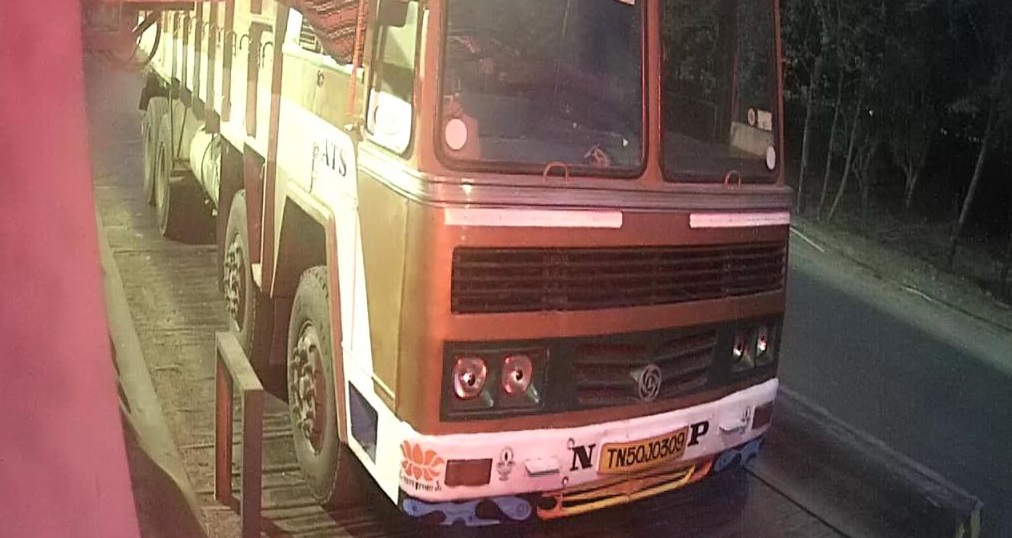

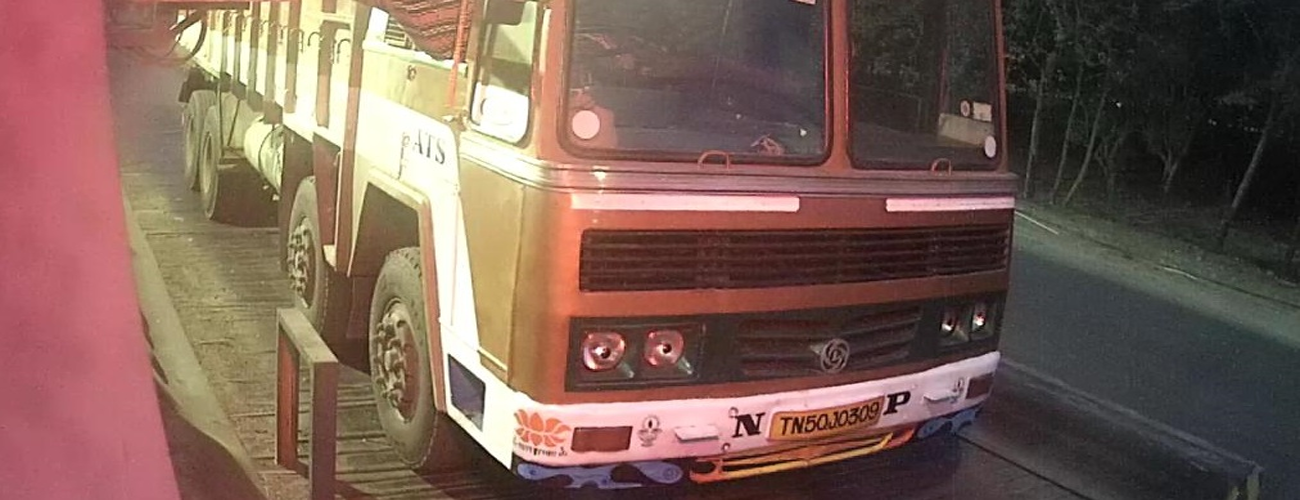

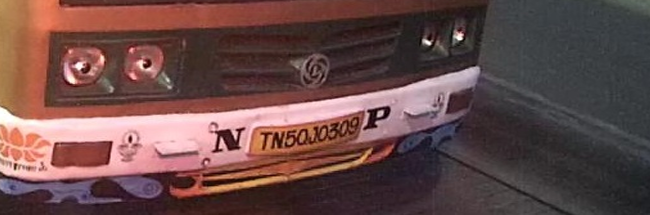

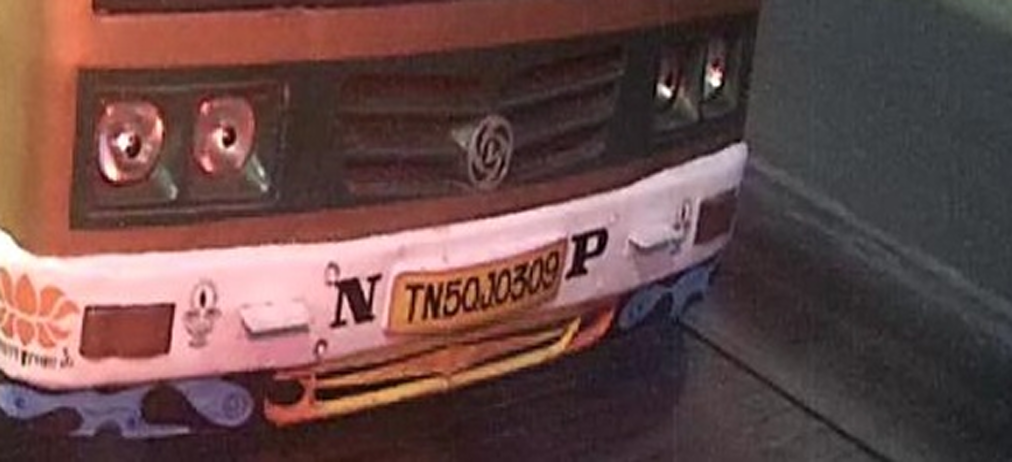

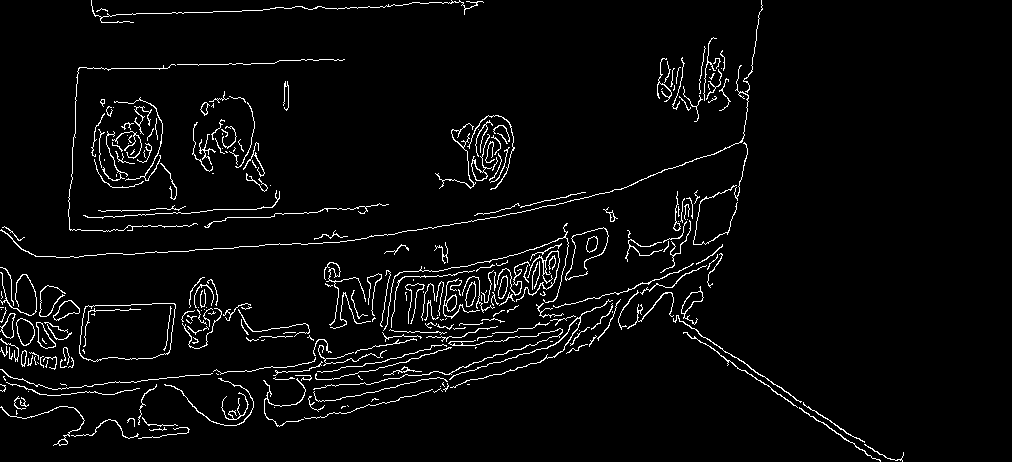

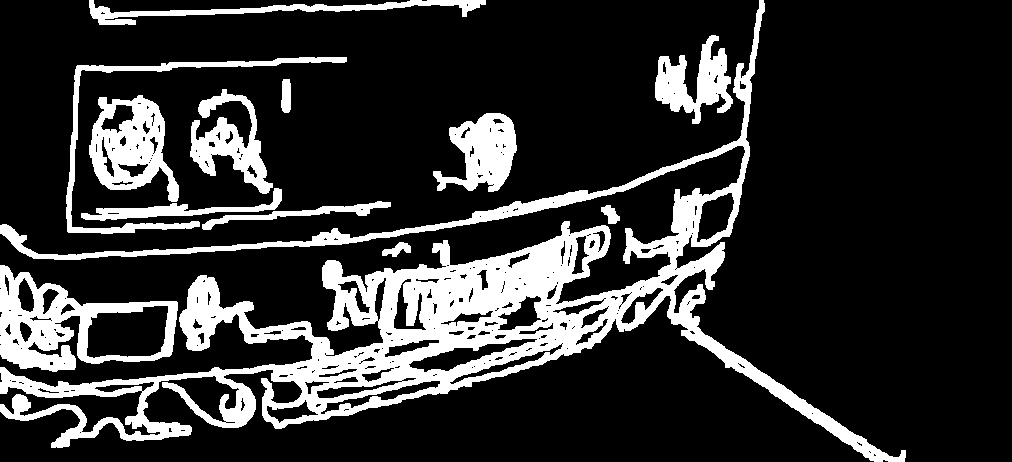

Number of Contours found = 321


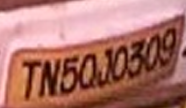

plate is found


In [0]:
import cv2
import numpy as np
import PIL
from IPython.display import display

def cv2_imshow(a):
  """A replacement for cv2.imshow() for use in Jupyter notebooks."""
  a = a.clip(0, 255).astype('uint8')
  # cv2 stores colors as BGR; convert to RGB
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))


#__main__
#loading the image of the car
image1 = cv2.imread('/content/gdrive/My Drive/APNR/truck/truck2.jpg')
cv2_imshow(image1)
cv2.waitKey(0)
cv2.destroyAllWindows()
# since the size of the images that were provide were not uniform,
# i made them to be of constant size for easy further operation.
# the width of the image is larger than the height because we can get maximum information
# of the plate by increasing the width.
height_orginal,width_orginal=image1.shape[:2]
img_scaled = cv2.resize(image1, (1300, 500), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_scaled) 
cv2.waitKey(0)

height,width=img_scaled.shape[:2]
start_row,end_row = int(4*height/7),int(height)
start_coloumn,end_coloumn = int(4*width/10), int(9*width/10)

ROI=img_scaled[start_row:end_row,start_coloumn:end_coloumn]
roi_height,roi_width= ROI.shape[:2]
cv2_imshow(ROI)
cv2.waitKey(0)

scaling_factor_height=height_orginal/height
scaling_factor_width= width_orginal/width

#computing the orginal dimensions of ROI in the given image
h=scaling_factor_height*roi_height
w=scaling_factor_width*roi_width

ROI=cv2.resize(ROI,(int(w)*2,int(h)*2),interpolation=cv2.INTER_CUBIC)
cv2_imshow(ROI)
cv2.waitKey(0)
cv2.destroyAllWindows()


# Converting the image to the grayscale
gray1 = cv2.cvtColor(ROI,cv2.COLOR_BGR2GRAY)


# to remove the unwnated noises in the surroundings the image is blurred with a kernel size of 5x5 
bright=np.ones((3,3),dtype='uint8')*(1/9) #kernel matrix
gray=cv2.filter2D(gray1,-1,bright)


# Finding Canny edges
#canny edge algorithm will plot all the possible contours in the pre processed image
edged = cv2.Canny(gray, 5, 100)
cv2_imshow(edged)
cv2.waitKey(0)

# to remove unwanted minor edges morphological operation is done on the cannied image.
kernel = np.ones((5,5), np.uint8)
morph = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
# MORPH_OPEN : dilate and erode
# MORPH_CLOSE: Erode and Dilate

print('\n')

# to highlight the remaining edged Threshold is applied
ret,thresh = cv2.threshold(morph, 127, 255, cv2.THRESH_TOZERO)
thresh= cv2.dilate(thresh,kernel,iterations=1)
cv2_imshow(thresh)
cv2.waitKey(0)


im2,contours,hirarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
plate=contours[0];
#To find number of contours detected
print("Number of Contours found = " + str(len(contours)))
test=ROI
selected=[]
plate1=None
flag=0
error =0.7
aspect = 4.1667
rmin = aspect - aspect * error
rmax = aspect + aspect * error
minarea = 15 *15*aspect
maxarea = 125 * 125 * aspect

for e,k in enumerate(contours):
    x,y,w,h=cv2.boundingRect(k)
    img=ROI[y:y+h,x:x+w]
    #cv2_imshow(img)
    area = h*w
    r=w/h
    if(r<1):
        r=h/w
    canny_img=cv2.Canny(img,20,150)
    ret,thresh_img = cv2.threshold(canny_img, 127, 255, cv2.THRESH_TOZERO)
    im2,c,hi = cv2.findContours(canny_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if((minarea<area and maxarea>area) and (rmin<r and rmax>r) and len(c)>40):
      from keras.preprocessing import image
      test_image = img
      test_image=cv2.resize(test_image,(30,100),interpolation=cv2.INTER_CUBIC)
      test_image = image.img_to_array(test_image)
      test_image = np.expand_dims(test_image, axis = 0)
      result = classifier.predict(test_image)
      if (result[0][0] ==1) :
        x1,y1,w1,h1=cv2.boundingRect(k)
        plate1=ROI[y1:y1+int(h1),x1:x1+int(w1)]
        cv2_imshow(img)
        cv2.waitKey(0)
        print("plate is found")
        flag=1
        
if(flag==0):
    print("plate contour was not found")
cv2.waitKey(0)
cv2.destroyAllWindows()




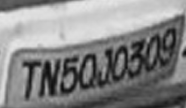

In [0]:
import pytesseract
import os
gray = cv2.cvtColor(plate1, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)



In [0]:
cv2.imwrite('test1.png',gray)

True

In [0]:
# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
from PIL import Image
import os

text = pytesseract.image_to_string(Image.open('test1.png'))
os.remove('test1.png')
print(text)

# show the output images
cv2_imshow("Output", gray)
cv2.waitKey(0)

TesseractError: ignored

/bin/bash: line 0: cd: /usr/local/bin/pytesseract: Not a directory
gdrive	sample_data  test1.png
